In [146]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
import shutil
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from sklearn.manifold import TSNE
import subprocess
import shlex


Aging is the time dependant weaking of the body. For example, aging in the pancreous can predispose people to diabetes (https://www.imrpress.com/journal/FBE/10/1/10.2741/e813). I will attempt to find theraputic targets that could be used to target aging in the pancreatus using scRNA-Seq data from  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81547.

A good target is a gene or pathway that:

(1) Has reletively constant expression accross cells from the same individual

(2) Is highly corraltive with age. Ideally, the relationship would be monotonic

(3) As a large magnatude of change with age

# Data Preprocessing

Creates the aggragated data for each sample in the ClupedData folder

This just puts the data in a nicer form for downstream processing: files named with the donor age and sex with the counts of each RNA in each row.

This is the description of the data:

	As organisms age, cells accumulate genetic and epigenetic changes that eventually lead to impaired organ function or catastrophic failure such as cancer. Here we describe a single-cell transcriptome analysis of 2544 human pancreas cells from donors, spanning six decades of life. We find that islet cells from older donors have increased levels of disorder as measured both by noise in the transcriptome and by the number of cells which display inappropriate hormone expression, revealing a transcriptional instability associated with aging. By analyzing the spectrum of somatic mutations in single cells from previously-healthy donors, we find a specific age-dependent mutational signature characterized by C to A and C to G transversions, indicators of oxidative stress, which is absent in single cells from human brain tissue or in a tumor cell line. Cells carrying a high load of such mutations also express higher levels of stress and senescence markers, including FOS, JUN, and the cytoplasmic superoxide dismutase SOD1, markers previously linked to pancreatic diseases with substantial age-dependent risk, such as type 2 diabetes mellitus and adenocarcinoma. Thus, our single-cell approach unveils gene expression changes and somatic mutations acquired in aging human tissue, and identifies molecular pathways induced by these genetic changes that could influence human disease. Also, our results demonstrate the feasibility of using single-cell RNA-seq data from primary cells to derive meaningful insights into the genetic processes that operate on aging human tissue and to determine which molecular mechanisms are coordinated with these processes.

This dataset contains scRNA-seq data on the pancreas of humans of various ages.

In [64]:
path = 'GSE81547'
datasets = sorted([path+'/'+i for i in listdir(path)])

pd.read_csv(datasets[0],delimiter='\t',header=None)

,0,1
0,1/2-SBSRNA4,0
1,A1BG,0
2,A1BG-AS1,0
3,A1CF,0
4,A2LD1,0
...,...,...
23460,no_feature,407558
23461,ambiguous,3754
23462,too_low_aQual,0
23463,not_aligned,0


The files themselves don't contain any information on the samples. Clumn 0 contains the gene and column 1 contains the Transcript counts. The last 5 rows contains data on the RNA-Seq preprocessing. First lets use the metadata file to get the ages and sexes of each sample.

In [65]:
id2file = lambda id: [i for i in datasets if i[i.find('/')+1:i.find('_')] == id][0]
with open('GSE81547_series_matrix.txt') as f:
    for line in f:
        if line.startswith('!Series_sample_id'):
            identifier = line[len('!Series_sample_id\t')+1:-3].split(' ')
        if line.startswith('!Sample_title'):
            donor = [(int(i[1:i.find('yr')]),i[i.find('_')+1]) for i in line[len('!Sample_title\t'):].split('\t')]
            donor = [(i, [id2file(identifier[j]) for j,k in enumerate(donor) if k == i]) for i in set(donor)]
donor.sort()

In [150]:
for id,files in donor:
    dfs = [pd.read_csv(files[0],delimiter='\t',header=None)] + [pd.read_csv(f,delimiter='\t',header=None)[1] for f in files[1:]]
    totdata = pd.concat(dfs,axis=1).iloc[:-5, :]
    totdata.columns = ['Gene'] + list(range(len(totdata.columns)-1))
    totdata.to_csv(f'ClumpedData/{"0"*(id[0]<10)}{id[0]}_{id[1]}.csv',index=False,sep='\t')

Now we have a function that takes the file name and returns the metadata

# Data Cleaning

Let's start by cleaning the data

I will be using enhance from https://www.biorxiv.org/content/10.1101/655365v2.full

The algorithm is incredibly simple. It basically assumes the data has a large nullspace and the data is noisy and uses PCA to choose which dimensions to keep.

In [151]:
folder = 'ClumpedData/'
for file in listdir(folder):
    subprocess.call(shlex.split(f'python3 enhance/enhance.py -f {folder+file} -o DenoisedData/{file}'))


Now that the data is denoised, I can start removing genes that won't help me find a theraputic target for aging.

The first thing to do would be removing genes whose standard deviation is larger within groups that throughout groups.

In [169]:
folder = 'DenoisedData/'
stds = []
means = []
for i,f in enumerate(sorted(listdir(folder))):
    df = pd.read_csv(folder+f,delimiter='\t')
    counts = df[df.columns[1:]]
    genes = df['Gene']
    print('Genes X Cells',counts.shape)
    genemean = counts.mean(axis=1)
    genestd = counts.std(axis=1)
    stds += [genestd]
    means += [genemean]

stds = np.array(list(stds))
means = np.array(list(means))
outgroupstd = means.var(axis=0)
ingroupstd = stds.max(axis=0)
print('Failed genes due to high in group variance:',sum(ingroupstd >= outgroupstd))
print('Possible genes:',sum(ingroupstd < outgroupstd))
potentialgenes = genes[ingroupstd < outgroupstd]


Genes X Cells (23460, 221)
Genes X Cells (23460, 331)
Genes X Cells (23460, 178)
Genes X Cells (23460, 505)
Genes X Cells (23460, 286)
Genes X Cells (23460, 474)
Genes X Cells (23460, 277)
Genes X Cells (23460, 272)
Failed genes due to high in group variance: 17576
Possible genes: 5884


Let's search for any genes that highly corrolate with age. They would be potential targets

In [222]:
print(means.shape)
t = [int(i[:2]) for i in sorted(listdir(folder))]
goodinds = []
for i,y in enumerate(means[:,potentialgenes.index].T):
    if np.std(y) > 1:
        r,p = sp.stats.pearsonr(t,y)
        if abs(r) > 0.8 and p < 0.05:
            goodinds += [i]


print('Corrolated genes that also work with the variance criteria:',len(goodinds))

(8, 23460)
Corrolated genes that also work with the variance criteria: 29


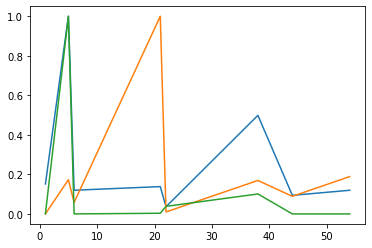

In [223]:
plt.plot(t,means[:,goodinds[:3]]/means[:,goodinds[:3]].max(axis=0))

(23460, 221)
(23460, 331)
(23460, 178)
(23460, 505)
(23460, 286)
(23460, 474)
(23460, 277)
(23460, 272)


Text(0, 0.5, 'Number of Genes with this Expression')

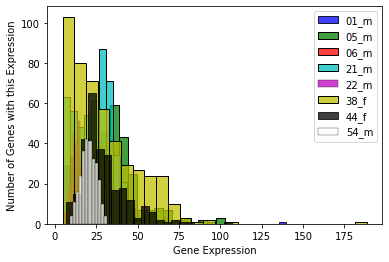

In [156]:
folder = 'DenoisedData/'
clr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i,f in enumerate(sorted(listdir(folder))):
    df = pd.read_csv(folder+f,delimiter='\t')
    counts = df[df.columns[1:]]
    genes = counts.shape[0]
    cells = counts.shape[1]
    print(counts.shape)
    genemean = counts.mean(axis=0)
    genevar = counts.std(axis=0)

    sb.histplot(genemean,label=f[:-4],color=clr[i])
plt.legend()
plt.xlabel('Gene Expression')
plt.ylabel('Number of Genes with this Expression')
# plt.plot(sorted(genemean))
# plt.plot(sorted(cellmean))
# sb.distplot(cellsum[cellsum < 100])

(23460, 474)


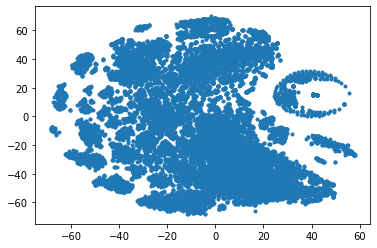

In [155]:
folder = 'DenoisedData/'
f = listdir(folder)[0]


df = pd.read_csv(folder+f,delimiter='\t')
counts = np.array(df[df.columns[1:]])
genes = counts.shape[0]
cells = counts.shape[1]
print(counts.shape)
genemean = counts.mean(axis=0)
genevar = counts.var(axis=0)
cellsum = counts.sum(axis=1)
# plt.plot(np.array(sorted(genevar))/max(genevar))
# plt.plot(np.array(sorted(genemean))/max(genemean))
x = TSNE().fit_transform(counts)
plt.plot(x[:,0],x[:,1],'.')
# plt.plot(x)

(23460, 2)


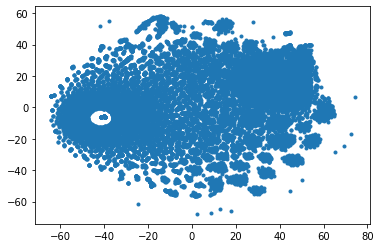

In [144]:
print(x.shape)